# Simmulated annealing

In [5]:
import networkx as nx
import pickle
from networkx.utils import open_file
import numpy as np
import random

In [6]:
# Load the graph
@open_file(0, mode="rb")
def pickle_load(path):
    return pickle.load(path)

G = pickle_load("./data/graph.gpickle")

### Hyperparameters

In [7]:
# Interrail travel days constraints
travel_days = 4
travel_day_max_time = 9 *60

# Travel destination constraints
total_travel_days = 12
start = "Brussels"
end = "Belgrade"

# start = "Kiruna"
# end = "Berlin"

# Travel constraints
city_weights_user = {
    "Amsterdam": 4,
    "Berlin": 4,
    "Stockholm":3,
    "Wien": 3,
    "Krakow": 3,
    #"Praha": 6,
    #"Krakow": 5
}
city_weights_base = 1

# add "score" feature to nodes
for city, data in G.nodes(data=True):
    if city in city_weights_user:
        G.nodes[city]["score"] = city_weights_user[city]
    elif city == start:
        G.nodes[city]["score"] = 0
    else:
        G.nodes[city]["score"] = city_weights_base

### Pseudocode  Simulated Annealing:


>```
>Simulated annealing (Tmax, Tmin, r, NT):
>    choose initial best_path that starts in start_city and ends in end_city
>    T := Tmax
>    while T > Tmin
>        repeat NT times:
>            neighbor_paths := generate_neighbor_paths(best_path)    
>            for neighbor_path in neighbor_paths:
>               if score(neighbor_path) > score(best_path) then accept 
>                   best_path := neighbor_path
>               else accept with probability exp( (f(x) - f(xn))/T*5)
>                   best_path := neighbor_path
>               T := T * r
>    return best_path  
>```

### Find initial path 

The initial path is based on the shortest route possible from start city to end city and has to be  of lenght: 

        visited_cities = travel_days + 1 

In [8]:
def find_single_path(G, source, target, travel_days, travel_day_max_time):
    simple_paths = nx.simple_paths.shortest_simple_paths(G, source=source, target=target, weight="time")

    for simple_path in simple_paths:
        if len(simple_path) >= travel_days + 1:
            # check if the path is feasible within the time travel_days * travel_day_max_time   
            total_time = sum(min(G.edges[simple_path[i], simple_path[i+1]]["time"], travel_day_max_time) for i in range(len(simple_path)-1)) 
            if total_time <= travel_day_max_time * travel_days:
                # make sure that simple_path has length of travel_days
                # indices = np.linspace(0,len(simple_path)-1, travel_days+1, dtype=int)
                initial_path = [simple_path[0]] 
                middle_ind = sorted(random.sample(range(1, len(simple_path)-1), travel_days-1))
                initial_path.extend(simple_path[i] for i in middle_ind)
                initial_path.append(simple_path[-1])
                return initial_path
            else:
                return False


path = find_single_path(G, start, end, travel_days, travel_day_max_time)  
print(path)  

['Brussels', 'München', 'Wien', 'Budapest', 'Belgrade']


### Define neighbors of a path

A neighbor_path is a path that takes one random node in the path and swaps that node with all its neighbor nodes.

In [9]:
def get_neighbors_path(G, path):

    index = np.random.randint(1,len(path)-1) 
    new_city = G.neighbors(path[index])
    
    neighbor_paths = []
    for city in new_city:
        if city in path:
            continue
        neighbor = path[:index] + [city] + path[index +1:]
        neighbor_paths.append(neighbor)
    
    return neighbor_paths

neighbors = get_neighbors_path(G, path)
for n in neighbors:
    print(n)

['Brussels', 'Venezia', 'Wien', 'Budapest', 'Belgrade']
['Brussels', 'Milan', 'Wien', 'Budapest', 'Belgrade']
['Brussels', 'Zurich', 'Wien', 'Budapest', 'Belgrade']
['Brussels', 'Frankfurt', 'Wien', 'Budapest', 'Belgrade']
['Brussels', 'Berlin', 'Wien', 'Budapest', 'Belgrade']
['Brussels', 'Hamburg', 'Wien', 'Budapest', 'Belgrade']
['Brussels', 'Praha', 'Wien', 'Budapest', 'Belgrade']


Next, we need to check if the neighbor_path is a path that is possible within the travel time.

In [10]:
def shortest_path(G, source, target, weight="time"):
    path = nx.shortest_path(G, source=source, target=target, weight=weight)
    time_sum = sum([G.edges[path[i], path[i+1]]["time"] for i in range(len(path)-1)])
    return path, time_sum

def check_proposed_path(G, proposed_path, travel_day_max_time):
    """
    Check if a proposed path is valid
    """
    for i, j in zip(proposed_path[:-1], proposed_path[1:]):
        #check if i and j are neighbors or if shortest path is less than travel_day_max_time
        _, time = shortest_path(G, i, j)

        if j in G.neighbors(i) or time < travel_day_max_time:
            continue
        else:
             return False
    return True

def get_path_score(G, path):
    if check_proposed_path(G, path, travel_day_max_time):
        return sum([G.nodes[city]["score"] for city in path[1:-1]])
    else: 
        return 0

for n in neighbors:
    print(check_proposed_path(G, n, travel_day_max_time), get_path_score(G, n))

False 0
False 0
True 5
True 5
True 8
False 0
False 0


### SA algorithm

In [11]:
def simulated_annealing(G, f, x0, hyperparameters):
    """
    Simple simulated annealing for a one-dimensional continous problem
    Inputs:
        - f : function to be optimized
        - x0 : starting point (float)
        - hyperparameters: dict with
                * Tmax : maximum (starting) temperature
                * Tmin : minimum (stopping) temperature
                * sigma : standard deviation for sampling a neighbor
                * r : rate of cooling
                * NT : number of iterations with fixed temperature --> how many neighbours you choose
    Outputs:
            - xstar : obtained minimum
            - xpath : path of x-values explored
            - fbest : best function values in each iteration
            - temperatures : the temperature of each iteration
    """
    # get hyperparameters
    Tmax = hyperparameters['Tmax']
    Tmin = hyperparameters['Tmin']
    r = hyperparameters['r']
    NT = hyperparameters['NT']

    # init outputs
    x = x0.copy() #current x
    temp = Tmax
    xstar = x.copy() #maximum x
    fstar = f(G, xstar) #maximum score
    xpaths = [x.copy()]
    fpaths = [fstar]
    temperatures = [temp]
    func = []


    while temp > Tmin:
        for i in range(NT):
            neighbor_paths = get_neighbors_path(G, xstar)

            for neighbor in neighbor_paths:
                fnew = f(G, neighbor)
                if fnew > fstar and fnew > 0:
                    xstar= neighbor.copy()
                    fstar = fnew
                elif  np.exp((-fstar+fnew)/temp*5) > np.random.rand():
                    xstar= neighbor.copy()
                    fstar= fnew

                xpaths.append(xstar.copy())
                fpaths.append(fstar)                            
                temperatures.append(temp)
                temp *= r

    return xstar, xpaths, fpaths, temperatures,func

In [12]:
hyperparameters = {'Tmax' : 10, 'Tmin' : 0.1, 'r' : 0.95, 'NT' : 20}    

P = find_single_path(G, source=start, target=end, travel_days=4,  travel_day_max_time = travel_day_max_time)

xstar, xpaths, fpaths, temperatures,func = simulated_annealing(G, f=get_path_score, x0=P, hyperparameters=hyperparameters)

print(fpaths)
print(xstar)

[5, 8, 8, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
['Brussels', 'Berlin', 'Wien', 'Budapest', 'Belgrade']


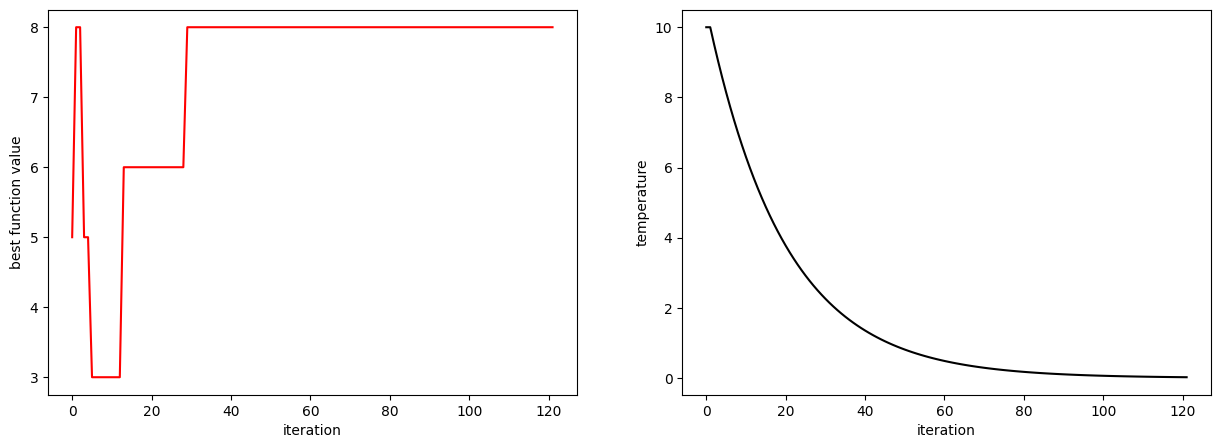

In [13]:
from matplotlib import pyplot as plt

fig, ( ax1,ax2) = plt.subplots(ncols=2,figsize=(15, 5))

ax1.plot(fpaths, color="red")
ax1.set_xlabel('iteration')
ax1.set_ylabel('best function value')

ax2.plot(temperatures, color="black")
ax2.set_xlabel('iteration')
ax2.set_ylabel('temperature')

plt.show()

### Final result

For this, we run the algorithm multiple times, to get the best paths found by the algorithm. It is possible that the algorithm gets stuck sometimes in a local maximum and returns a path that does not exist. We keep only those paths that do exist.

In [14]:
myset = set()

for i in range(20):
    P = find_single_path(G, source=start, target=end, travel_days=4,  travel_day_max_time = travel_day_max_time)
    xstar, xpaths, fpaths, temperatures,func = simulated_annealing(G, f=get_path_score, x0=P, hyperparameters=hyperparameters)
    # add the list xstar to myset
    myset.add(tuple(xstar))


for path in myset:
    if check_proposed_path(G, path, travel_day_max_time):
        print(path, get_path_score(G, path))
    

('Brussels', 'Amsterdam', 'München', 'Budapest', 'Belgrade') 6
('Brussels', 'Berlin', 'Wien', 'Budapest', 'Belgrade') 8
